In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy
import time

# === 1. Generate ADC data ===

In [129]:
# def generate_adc_data_cube(Q, distance, velocity, Theta, Phi, SNR):
def generate_adc_data_cube(target_dict, SNR):
    c = 3e+8                                # 光速
    fc = 77e+9                              # 發射訊號載頻
    Tc = 10e-6                              # 時間週期
    fs = 25.6e+6                            # 取樣頻率(sample frequence)/取樣率(sampling rate)
    Fs = 1/fs                               # 取樣週期(sampling period)/取樣間隔(sampling interval)
    t = np.arange(0, Tc, Fs)                # 時間向量 (共256個點
    Sample_rate = len(t)                    # 取樣頻率256個點
    bw = 500e+6                             # 發射訊號帶寬
    k = bw/Tc                               # 斜率
    P = 100                                 # chirp 的數目
    # distance = np.array([10, 30, 50])       # 目標距離雷達50m
    # velocity = np.array([-20, 0, 20])       # 目標距離雷達的相對速度20m/s
    # Theta = np.array([-50, 0, 50])          # 目標入射角度
    # Phi = np.array([-30, -20, -10])         # 目標發射角度
    # fb = 2*k*distance/c                     # 訊號關於距離頻率
    # fd = 2*velocity*fc/c                    # 訊號關於速度頻率
    M = 4                                   # 接收天線數目
    N = 3                                   # 發射天線數目
    # M = 10                                  # 接收天線數目
    # N = 10                                  # 發射天線數目
    # dm = np.arange(0, M, 1);                # 接收天線的索引位置
    # dn = np.arange(0, N, 1);                # 發射天線的索引位置
    lamda = c/fc                            # 訊號波長
    d = lamda/2                             # 天線間距
    # Q = 3;                                  # 目標數目
    # SNR = 10;                               # SNR
    Np = 1                                  # 雜訊功率
    An = np.sqrt(Np)                        # 雜訊振幅
    Sp = Np*10**(SNR/10)                    # 訊號功率
    As = np.sqrt(Sp)                        # 訊號振幅
    DOA = 0
    DOD = 0
    #------------------------------- 產生資料 ---------------------------------#
    Element = 0;                            # 天線數目MxN
    adc_data_cube = np.zeros((Sample_rate, P, (M*N)), dtype=np.complex64)                # 存儲所有天線的中頻訊號
    for n in range(N):                                                                   # 發射天線迴圈
        for m in range(M):                                                               # 接收天線迴圈
            data = np.zeros((Sample_rate, P), dtype=np.complex64)                        # 存儲所有目標的中頻訊號
            for key in target_dict:
                distance = target_dict[key][0][0]
                velocity = target_dict[key][0][1]
#                 main_DOA = target_dict[key][0][2]
#                 main_DOD = target_dict[key][0][3]
                # theta_sum = np.sum(target_dict[key][1])
                fb = 2*k*distance/c                                                      # 訊號關於距離頻率
                fd = 2*velocity*fc/c 
                
                IF_data = np.zeros((Sample_rate, P), dtype=np.complex64)                 # 存儲含有雜訊的中頻訊號
                for p in range(P):
                    timeSignal = np.exp(1j*2*np.pi*((fb+fd)*t))                    # 含時間的訊號
                    velocitySignal = np.exp(1j*2*np.pi*fd*(p+1)*Tc)                   # 含速度的訊號
                    distanceSignal = np.exp(1j*2*np.pi*fc*2*distance/c)               # 含距離的訊號
#                     DOD = np.exp(1j*2*np.pi*n*d*np.sin((Phi[q]*np.pi/180))/lamda)        # 離開角度訊號
#                     DOA = np.exp(1j*2*np.pi*m*d*np.sin((Theta[q]*np.pi/180))/lamda)      # 入射角度訊號                
                    for doa in target_dict[key][1]:            
                        DOA += np.exp(1j*2*np.pi*m*d*np.sin(doa*np.pi/180)/lamda)      # 入射角度訊號                      
                    for dod in target_dict[key][2]:                        
                        DOD += np.exp(1j*2*np.pi*n*d*np.sin(dod*np.pi/180)/lamda)      # 入射角度訊號 
                    DOA /= len(target_dict[key][1])
                    DOD /= len(target_dict[key][2])                
                
                    IF = As*(timeSignal*velocitySignal*distanceSignal*DOD*DOA);
                    # noise = An*(np.random.randn(1, Sample_rate)+1j*np.random.randn(1, Sample_rate))/np.sqrt(2)
                    # IF_data[:, p] = IF+noise;
                    IF_data[:, p] = IF;
                #-----------------------------------------------------------------#
                data = data+IF_data                                                      # 訊號疊加
            #-----------------------------------------------------------------#
            adc_data_cube[:, :, Element] = data
            Element = Element+1
    
    save_dict = {
    "adc_data_cube": adc_data_cube,
    # "theta": theta
    }
    save_path = "adc_data_with_theta.npy"
    np.save(save_path, save_dict)
    return adc_data_cube

# === 2. Range and doppler FFT  ===

In [130]:
def RV_fft(adc_data_cube, plot=True):
    # 輸出 shape: 256 range bins, 100 chirps, 12 antenna (3x4)
    c = 3e+8                                # 光速
    fc = 77e+9                              # 發射訊號載頻
    Tc = 10e-6                              # 時間週期
    fs = 25.6e+6                            # 取樣頻率(sample frequence)/取樣率(sampling rate)
    Fs = 1/fs                               # 取樣週期(sampling period)/取樣間隔(sampling interval)
    t = np.arange(0, Tc, Fs)                # 時間向量 (共256個點)
    Sample_rate = len(t)                    # 取樣頻率256個點
    bw = 500e+6                             # 發射訊號帶寬
    k = bw/Tc                               # 斜率
    P = 100                                 # chirp 的數目
    M = 4                                   # 接收天線數目
    N = 3                                   # 發射天線數目
    # M = 10                                   # 接收天線數目
    # N = 10                                   # 發射天線數目
    lamda = c/fc                            # 訊號波長
    #----------------------------------------------------------------------------------------------------#
    dataSum = np.zeros((Sample_rate, P), dtype=np.complex64)
    dataSum_3d = np.zeros((Sample_rate, P, M*N), dtype=np.complex64)
    for i in range(M*N):
        data = adc_data_cube[:, :, i]
        range_spectrum = np.fft.fft(data, axis=0)                                # 估測的距離頻譜
        doppler_spectrum = np.fft.fft(range_spectrum, axis=1)                    # 估測的速度頻譜
        rvSpectrum_shift = np.fft.fftshift(doppler_spectrum, axes=1)             # 將頻域中心化（方便觀察）
        dataSum = dataSum+np.abs(rvSpectrum_shift)                               # 所有天線接收資料的總和，資料維度256x100
        dataSum_3d[:, :, i] = rvSpectrum_shift 
    rvSpectrum = dataSum/(M*N)
    
    range_res = c * fs / (2 * k * Sample_rate)                                   # 每個 range bin 的距離解析度
    max_range = range_res * Sample_rate                                          # 最遠距離
    ranges = np.linspace(0, max_range, Sample_rate)                              # x 軸：range bin 對應的距離
    
    # Doppler 計算
    doppler_res = 1 / (P * Tc)                                                   # 頻率解析度
    max_doppler = doppler_res * P / 2
    velocities = np.linspace(-max_doppler, max_doppler, P) * lamda / 2           # y 軸：Doppler bins 對應速度
    
    # 生成 meshgrid 對應 range 和 velocity 軸
    V, R = np.meshgrid(velocities, ranges)
    Z = rvSpectrum
    
    # 畫 3D 圖
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(V, R, Z, cmap='viridis')
    
    ax.set_xlabel('Velocity (m/s)')
    ax.set_ylabel('Range (m)')
    ax.set_zlabel('Magnitude (dB)')
    ax.set_title('3D Range-Doppler Map')
    fig.colorbar(surf, shrink=0.5, aspect=10, label='Magnitude (dB)')
    ax.view_init(elev=90, azim=0)
    plt.tight_layout()
    plt.show()
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(V, R, Z, cmap='viridis')
    
    ax.set_xlabel('Velocity (m/s)')
    ax.set_ylabel('Range (m)')
    ax.set_zlabel('Magnitude (dB)')
    ax.set_title('3D Range-Doppler Map')
    fig.colorbar(surf, shrink=0.5, aspect=10, label='Magnitude (dB)')
    ax.view_init(elev=0, azim=0)
    plt.tight_layout()
    plt.show()
    return rvSpectrum , dataSum_3d


# === 3. CFAR  ===

In [131]:
def cfar_2d(signal, num_train, num_guard, threshold_scal):
    cfar_output = np.zeros_like(signal, dtype=np.uint8)
    row_len, col_len = signal.shape

    for i in range(num_train + num_guard, row_len - (num_train + num_guard)):
        for j in range(num_train + num_guard, col_len - (num_train + num_guard)):
            row_start = i - num_train - num_guard
            row_end   = i + num_train + num_guard + 1
            col_start = j - num_train - num_guard
            col_end   = j + num_train + num_guard + 1

            guard_row_start = i - num_guard
            guard_row_end   = i + num_guard + 1
            guard_col_start = j - num_guard
            guard_col_end   = j + num_guard + 1

            window = signal[row_start:row_end, col_start:col_end].copy()

            # 將 guard cells + CUT 設為 0，不參與平均
            window[
                guard_row_start - row_start : guard_row_end - row_start,
                guard_col_start - col_start : guard_col_end - col_start
            ] = 0

            # 去除 0 的部分來算平均
            if np.count_nonzero(window) > 0:
                noise_level = np.sum(window) / np.count_nonzero(window)
                threshold = noise_level * threshold_scale
                # print(f"range {i}, doppler {j}, thres {threshold}")
                if signal[i, j] > threshold:
                    cfar_output[i, j] = 1

    return cfar_output


def cfar_detect(rvSpectrum, num_train, num_guard, threshold_scale):
    c = 3e8
    fc = 77e9
    Tc = 10e-6
    fs = 25.6e6
    Fs = 1 / fs
    t = np.arange(0, Tc, Fs)
    Sample_rate = len(t)
    bw = 500e6
    k = bw / Tc
    P = 100
    lamda = c / fc

    # 執行 2D CFAR 偵測
    cfar_mask = cfar_2d(rvSpectrum, num_train, num_guard, threshold_scale)

    # 擷取偵測點
    detections = []
    for i in range(cfar_mask.shape[0]):
        for j in range(cfar_mask.shape[1]):
            if cfar_mask[i, j] == 1:
                detections.append({
                    "range_bin": i,
                    "doppler_bin": j,
                    "magnitude": rvSpectrum[i, j]
                })

    # 軸資料
    range_res = c * fs / (2 * k * Sample_rate)
    doppler_res = 1 / (P * Tc)
    ranges = np.linspace(0, range_res * Sample_rate, Sample_rate)
    velocities = np.linspace(-P / 2, P / 2 - 1, P) * doppler_res * lamda / 2
    V, R = np.meshgrid(velocities, ranges)
    Z = rvSpectrum

    detect_ranges = [ranges[d["range_bin"]] for d in detections]
    detect_velocities = [velocities[d["doppler_bin"]] for d in detections]
    detect_mags = [d["magnitude"] for d in detections]
    
    for d in detections:
        d["range"] = ranges[d["range_bin"]]
        d["velocity"] = velocities[d["doppler_bin"]]


    # 3D 圖
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(V, R, Z, cmap='viridis', alpha=0.8)
    ax.scatter(detect_velocities, detect_ranges, detect_mags, c='r', s=40, label='CFAR detections')
    ax.set_xlabel('Velocity (m/s)')
    ax.set_ylabel('Range (m)')
    ax.set_zlabel('Magnitude')
    ax.set_title('3D Range-Doppler Map with CFAR Detections')
    ax.view_init(elev=30, azim=135)
    fig.colorbar(surf, shrink=0.5, aspect=10, label='Magnitude')
    ax.legend()
    plt.tight_layout()
    plt.show()

    # # 2D 圖
    # plt.figure(figsize=(10, 6))
    # plt.pcolormesh(velocities, ranges, rvSpectrum, shading='auto', cmap='viridis')
    # plt.colorbar(label='Magnitude')
    # plt.xlabel('Velocity (m/s)')
    # plt.ylabel('Range (m)')
    # plt.title('2D Range-Doppler Map with CFAR Detections')
    # plt.scatter(detect_velocities, detect_ranges, c='r', marker='x', label='CFAR Detections')
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

    return detections

# === 4. AoA FFT  ===

In [132]:
def aoa_dpu(dataSum_3d, range_doppler_detection_list, Q):
    M=4
    fft_points=256    
    c = 3e8
    fc = 77e9
    bw = 500e6
    fs = 25.6e6
    Tc = 10e-6
    M = 4                                   # 接收天線數目
    N = 3                                   # 發射天線數目
    # M = 10                                   # 接收天線數目
    # N = 10                                   # 發射天線數目
    k = bw / Tc
    P = 100
    Sample_rate = 256
    lamda = c / fc
    d = lamda / 2
    spec_DOD = np.zeros((fft_points))
    spec_DOA = np.zeros((fft_points))

    point_cloud = []
    detection_list = range_doppler_detection_list

    for det in detection_list:
        rbin = det["range_bin"]
        dbin = det["doppler_bin"]

        # Range 計算
        range_res = c * fs / (2 * k * Sample_rate)
        max_range = range_res * Sample_rate
        range_axis = np.linspace(0, max_range, Sample_rate)
        rng = range_axis[rbin]

        # Doppler 計算
        doppler_res = 1 / (P * Tc)
        max_doppler = doppler_res * P / 2
        vel_axis = np.linspace(-max_doppler, max_doppler, P) * lamda / 2
        vel = vel_axis[dbin]
        #--------------------------------------------------------------------------------------------------#
        # 取出該點對應天線的資料 (shape: [M,])
        antenna_symbols = dataSum_3d[rbin, dbin, :]  # shape = (12,)
        # 重排成虛擬陣列：這裡假設為 2D 平面 (azimuth x elevation)，簡單重排為 3x4 (N x M)
        antenna_matrix = antenna_symbols.reshape(N, M)  # shape = (3, 4)

        Y_DOD = antenna_matrix[:, 0]
        spec_DOD = np.abs(np.fft.fftshift(np.fft.fft(Y_DOD, n=fft_points, axis=0), axes=0))

        Y_DOA = antenna_matrix[0, :]
        spec_DOA = np.abs(np.fft.fftshift(np.fft.fft(Y_DOA, n=fft_points, axis=0), axes=0))


        # 角度軸
        DOD_axis = np.arcsin(np.linspace(-1, 1, fft_points)) * 180 / np.pi
        DOA_axis = np.arcsin(np.linspace(-1, 1, fft_points)) * 180 / np.pi  


        # 角度計算
        from scipy.signal import find_peaks
        peakIndex_DOD, _ = find_peaks(spec_DOD)                       # 找到峰值發射角度的索引值
        peakValue_DOD = spec_DOD[peakIndex_DOD]                       # 找到峰值的發射角度
        DOD_indices = np.argsort(peakValue_DOD)[::-1]                 # 功率大到小排序並得到索引值
        DOD_est = DOD_axis[peakIndex_DOD[DOD_indices]]                # 得到相對應的角度
        DOD_angle = DOD_est[0]                                        # 取得前Q個目標



        peakIndex_DOA, _ = find_peaks(spec_DOA)                       # 找到峰值發射角度的索引值
        peakValue_DOA = spec_DOA[peakIndex_DOA]                       # 找到峰值的發射角度
        DOA_indices = np.argsort(peakValue_DOA)[::-1]                 # 功率大到小排序並得到索引值
        DOA_est = DOA_axis[peakIndex_DOA[DOA_indices]]                # 得到相對應的角度
        DOA_angle = DOA_est[0]                                        # 取得前Q個目標 

        #--------------------------------------------------------------------------------------------------#    
        # x = rng * np.sin(np.deg2rad(Ele_angle)) * np.cos(np.deg2rad(Azi_angle))
        # y = rng * np.sin(np.deg2rad(Ele_angle)) * np.sin(np.deg2rad(Azi_angle))
        # z = rng * np.cos(np.deg2rad(Ele_angle))

        x = rng *  np.sin(np.deg2rad(DOA_angle))
        y = rng *  np.cos(np.deg2rad(DOA_angle))
        z = 0;

        point_cloud.append({
            "x": x,
            "y": y,
            "z": z,
            "range": rng,
            "azi": DOA_angle,            
            "velocity": vel,
        })
        #--------------------------------------------------------------------------------------------------#
        # plt.figure(figsize=(10, 4))
        # plt.plot(DOD_axis, spec_DOD, 'b-')
        # plt.plot(DOA_axis, spec_DOA, 'r-')
        # plt.title("1D DOA Angle Spectrum")
        # plt.xlabel("Angle (deg)")
        # plt.ylabel("Power")
        # plt.grid(True)
        # plt.xlim([-90, 90])
        # plt.xticks(np.arange(-90, 91, 10))
        # plt.tight_layout()
        # plt.show()
    return point_cloud

# === 6. Main ===

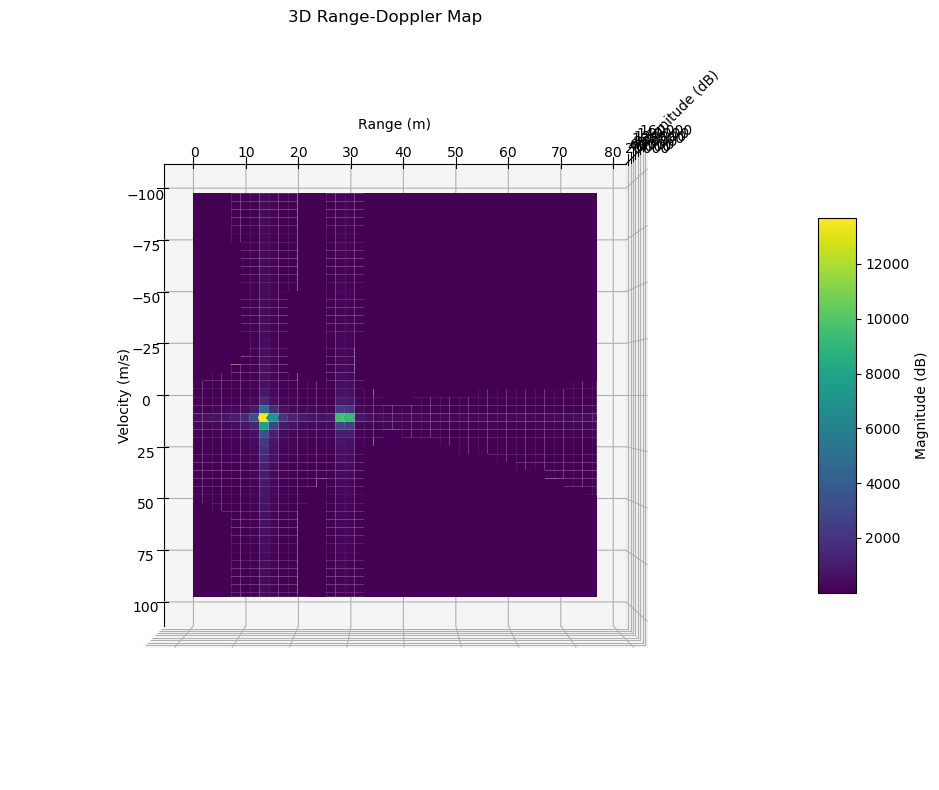

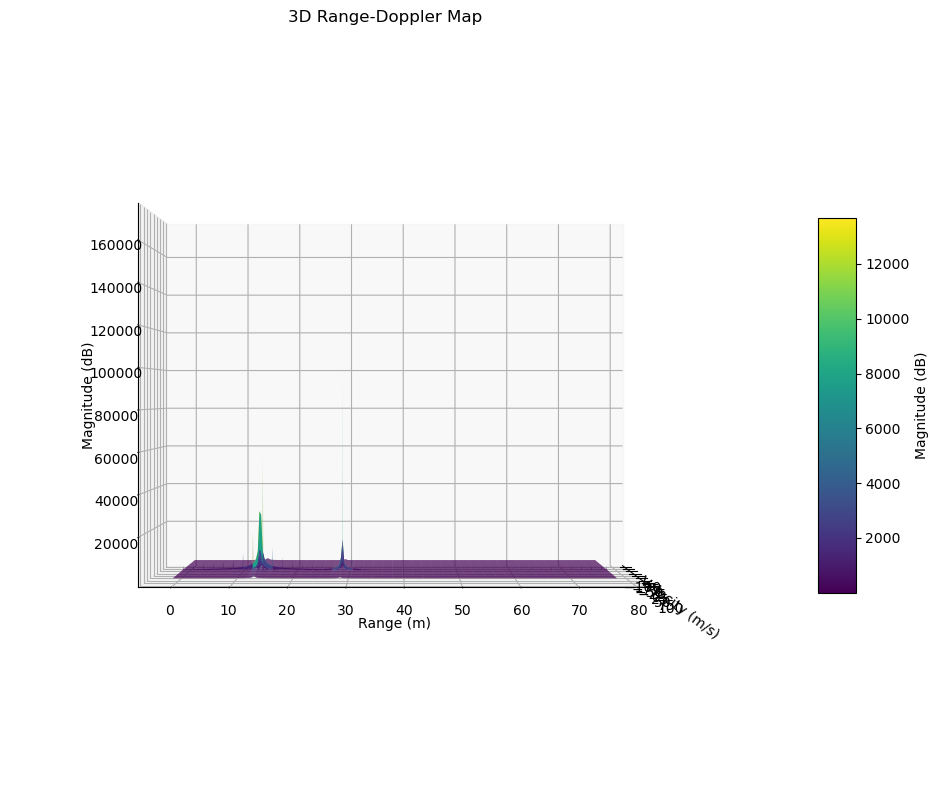

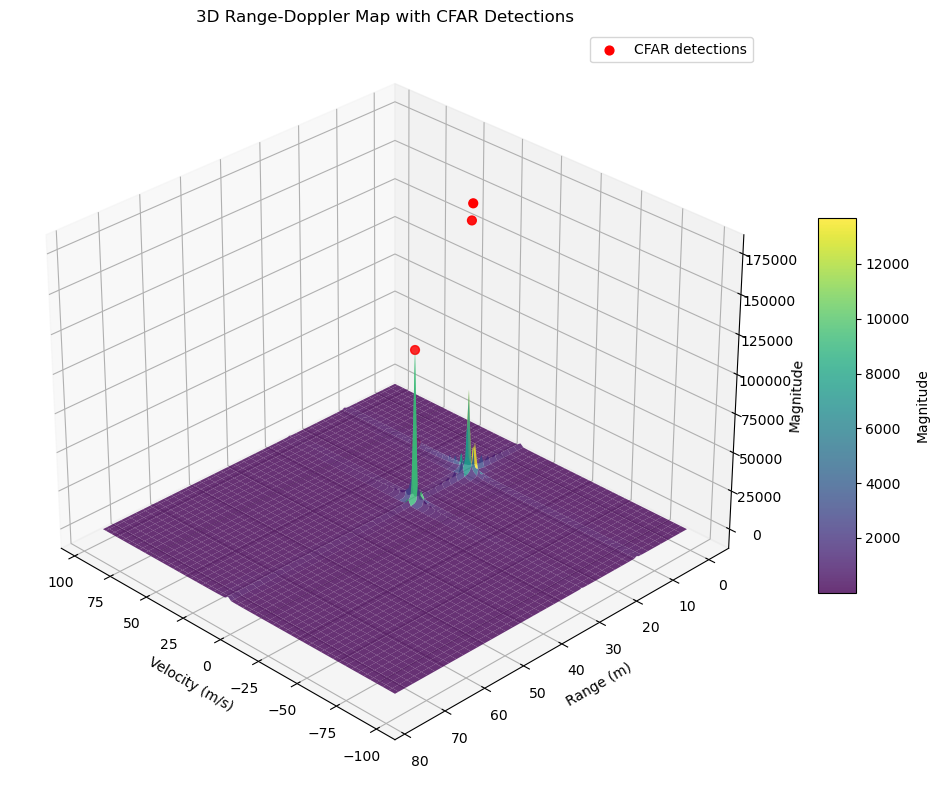

In [133]:
# R = np.array([10, 30, 50])              # 目標距離雷達
# V = np.array([-20, 0, 20])              # 目標距離雷達的相對速度
# Theta = np.array([-50, 0, 50])          # 目標入射角度
# Phi = np.array([-30, -20, -10])         # 目標發射角度
# Q = 3                                   # 目標數目
# R = np.array([10, 30])                  # 目標距離雷達
# V = np.array([-20, 0])                  # 目標距離雷達的相對速度
# Theta = np.array([-50, 0])              # 目標入射角度
# Phi = np.array([-30, -20])              # 目標發射角度
# Q = 2                                   # 目標數目
# R = np.array([10, 30])                    # 目標距離雷達
# V = np.array([-20, 0])                    # 目標距離雷達的相對速度
# Phi = np.array([0, 50])                   # 目標發射角度, -90~90
# Theta = np.array([-50, 10])               # 目標入射角度, -90~90
Q = 2                                     # 目標數目

target_dict = {
    'circle': [[28.7, 10, 11.9, 0],  [11.71, 11.9, 12.1, 12.29, 12.49, 12.68], [0, 0, 0, 0, 0, 0]],
    'rect': [[13.93, 10, -68.96, 0], [-48.12, -68.96], [0, 0]]
#     'circle': [[28.7, 10, 11.9, 0],  [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]],
#     'rect': [[13.93, 10, -68.96, 0], [0, 0], [0, 0]]    
}

SNR = 10
num_train = 10
num_guard = 4
threshold_scale = 100
#----------------------------------------------------------------#
adc_data_cube = generate_adc_data_cube(Q, target_dict, SNR)
rvSpectrum, dataSum_3d = RV_fft(adc_data_cube)
range_doppler_detection_list = cfar_detect(rvSpectrum, num_train, num_guard, threshold_scale)
point_cloud_list = aoa_dpu(dataSum_3d, range_doppler_detection_list, Q)


In [134]:
point_cloud_list

[{'x': -11.572262975778548,
  'y': 7.617040461883589,
  'z': 0,
  'range': 13.854117647058825,
  'azi': -56.64647616250882,
  'velocity': 10.822510822510822},
 {'x': -11.823833910034603,
  'y': 7.782628298011494,
  'z': 0,
  'range': 14.15529411764706,
  'azi': -56.64647616250882,
  'velocity': 10.822510822510822},
 {'x': 6.1711649365628585,
  'y': 27.93832140466768,
  'z': 0,
  'range': 28.611764705882354,
  'azi': 12.455792625905326,
  'velocity': 10.822510822510822},
 {'x': 6.236124567474047,
  'y': 28.232408998401024,
  'z': 0,
  'range': 28.91294117647059,
  'azi': 12.455792625905326,
  'velocity': 10.822510822510822}]

In [135]:
target_dict = {
    'circle': [[28.7, 10, 11.9, 0],  [11.71, 11.9, 12.1, 12.29, 12.49, 12.68], [0, 0, 0, 0, 0, 0]], 
    'rect': [[13.93, 10, -68.96, 0], [-48.12, -68.96], [0, 0]]
}